In [1]:
import pandas as pd
import requests as r
from sklearn.preprocessing import MultiLabelBinarizer

pd.options.display.float_format = "{:.2%}".format

In [2]:
r.get(f"""https://fr.openfoodfacts.org/api/v3/product/3166352967211.json""").json()[
    "product"
]

{'_id': '3166352967211',
 '_keywords': ['frai',
  'france',
  'nutriscore',
  'marie',
  'compotee',
  'tagliatelle',
  'colorant',
  'au',
  'base',
  'prepare',
  'plat',
  'additif',
  'parmesan',
  'san',
  'micro-onde',
  'crustace',
  'en',
  'conservateur',
  'pesto',
  'cuisine',
  'non-ue',
  'de',
  'rechauffer',
  'triman',
  'et',
  'ue',
  'sauce',
  'pate',
  'origine',
  'gamba',
  'tomate',
  'italie',
  'petite'],
 'added_countries_tags': [],
 'additives_debug_tags': [],
 'additives_n': 0,
 'additives_old_n': 0,
 'additives_old_tags': [],
 'additives_original_tags': [],
 'additives_prev_original_tags': [],
 'additives_tags': [],
 'allergens': 'en:crustaceans,en:eggs,en:gluten,en:milk,en:sulphur-dioxide-and-sulphites',
 'allergens_from_ingredients': 'en:gluten, blé, oeufs, crevettes, sulfites, fromage, blé',
 'allergens_from_user': '(en) en:crustaceans,en:eggs,en:gluten,en:milk,en:sulphur-dioxide-and-sulphites',
 'allergens_hierarchy': ['en:crustaceans',
  'en:eggs',
  

In [3]:
r.get(f"""https://fr.openfoodfacts.org/api/v3/product/3166352967211.json""").json()[
    "product"
]["allergens"]

'en:crustaceans,en:eggs,en:gluten,en:milk,en:sulphur-dioxide-and-sulphites'

In [4]:
def clean_text(txt):
    return txt.replace("fr:", "").replace("en:", "")


def get_product_allergens(barcode_list, feedback_list):
    allergens = []
    for barcode, feedback in zip(barcode_list, feedback_list):
        request = r.get(
            f"""https://fr.openfoodfacts.org/api/v3/product/{str(barcode)}.json"""
        ).json()["product"]
        allergens.append(
            [
                int(barcode),
                feedback,
                clean_text(request["allergens"]).split(","),
            ]
        )
    df = pd.DataFrame(
        allergens,
        columns=["code", "feedback", "allergens"],
    ).set_index("code")
    return df


def label_allergens(df):
    encoder = MultiLabelBinarizer()
    labeled_data = encoder.fit_transform(df["allergens"])
    return df.drop(columns=["allergens"]).merge(
        pd.DataFrame(labeled_data, columns=encoder.classes_, index=df.index),
        left_on="code",
        right_on="code",
    )

In [5]:
allergens_products = get_product_allergens(
    [
        3033490004743,
        8001505005592,
        8000500310397,
        7622210449283,
        8712566328208,
        3166352967211,
    ],
    ["ballonements", "boutons", "ballonements", "boutons", "ballonements", "boutons"],
)

allergens_products

,feedback,allergens
code,,
3033490004743,ballonements,[milk]
8001505005592,boutons,"[milk, nuts, soybeans]"
8000500310397,ballonements,"[gluten, milk, nuts, soybeans, Gs1:T4078:ML]"
7622210449283,boutons,"[eggs, gluten, milk, soybeans]"
8712566328208,ballonements,"[milk, nuts]"
3166352967211,boutons,"[crustaceans, eggs, gluten, milk, sulphur-diox..."


In [6]:
label_allergens_products = label_allergens(allergens_products)

label_allergens_products

,feedback,Gs1:T4078:ML,crustaceans,eggs,gluten,milk,nuts,soybeans,sulphur-dioxide-and-sulphites
code,,,,,,,,,
3033490004743,ballonements,0,0,0,0,1,0,0,0
8001505005592,boutons,0,0,0,0,1,1,1,0
8000500310397,ballonements,1,0,0,1,1,1,1,0
7622210449283,boutons,0,0,1,1,1,0,1,0
8712566328208,ballonements,0,0,0,0,1,1,0,0
3166352967211,boutons,0,1,1,1,1,0,0,1


In [7]:
label_allergens_products.groupby("feedback").mean()

,Gs1:T4078:ML,crustaceans,eggs,gluten,milk,nuts,soybeans,sulphur-dioxide-and-sulphites
feedback,,,,,,,,
ballonements,33.33%,0.00%,0.00%,33.33%,100.00%,66.67%,33.33%,0.00%
boutons,0.00%,33.33%,66.67%,66.67%,100.00%,33.33%,66.67%,33.33%


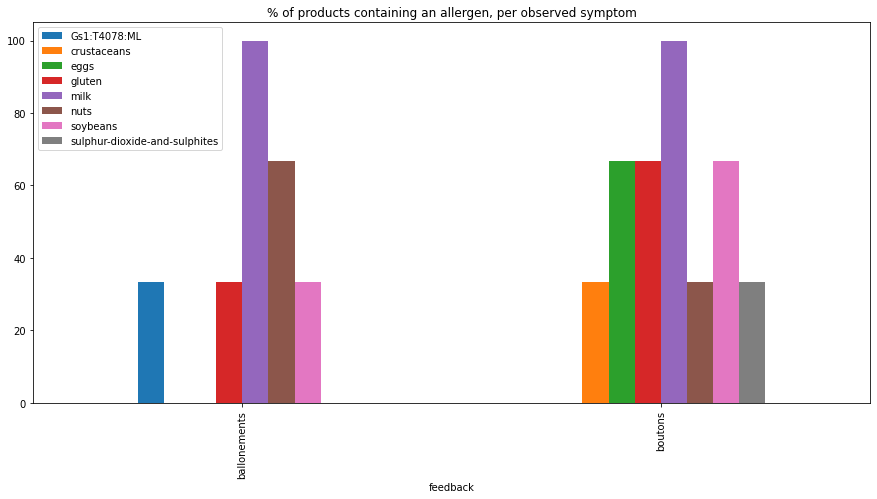

In [8]:
label_allergens_products.groupby("feedback").mean().apply(lambda x: x * 100).plot(
    kind="bar",
    title="% of products containing an allergen, per observed symptom",
    figsize=(15, 7),
);